In [1]:
import scipy.io as sio
import pandas as pd
import os
import numpy as np
import re
import keras
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout, Add, BatchNormalization,Conv1D, advanced_activations, UpSampling2D
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import Adam, SGD
from sklearn.metrics import mean_absolute_error, classification_report, max_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
'''%load_ext tensorboard
import tensorflow as tf
import datetime, os'''

Using TensorFlow backend.


'%load_ext tensorboard\nimport tensorflow as tf\nimport datetime, os'

Load and preprocess data

In [2]:
!unzip /content/85318_196940_bundle_archive.zip
inputData = pd.read_csv(r"/content/eeg_clean.csv");
#print(inputData.dtypes)
#print(inputData.columns)
#print("Data shape:",inputData.shape)
#print(inputData.head())
#print(inputData.describe())
#print(inputData.info())
# Check for any nulls
#print(inputData.isnull().sum())
inputData['eye']=inputData["eye"].astype('category')
inputData["eye"] = inputData["eye"].cat.codes

data=inputData.to_numpy()
temp=np.round(data[:,2])
data[:,2]=data[:,14]
data[:,14]=temp
dataC=data[data[:,14]==0,0:14]
dataO=data[data[:,14]==1,0:14]
dataC=np.transpose(dataC)
dataO=np.transpose(dataO)
print(np.shape(dataO))
print(np.shape(dataC))
dataOMat=np.zeros((114,14,1024))
dataCMat=np.zeros((87,14,1024))
count=0
for i in range(0,8257-1024,64):
  dataOMat[count,:,:]=(dataO[:,i:i+1024]-np.mean(dataO[:,i:i+1024]))/np.std(dataO[:,i:i+1024])
  count+=1
count=0
for i in range(0,6592-1024,64):
  dataCMat[count,:,:]=(dataC[:,i:i+1024]-np.mean(dataC[:,i:i+1024]))/np.std(dataC[:,i:i+1024])
  count+=1
#print(count)
print(np.shape(dataOMat))
print(np.shape(dataCMat))
dataX=np.append(dataOMat,dataCMat,axis=0)
dataY=np.append(np.ones(114),np.zeros(87))
dataX=np.reshape(dataX,(np.shape(dataX)[0],14,1024,1))
np.shape(dataX)

Archive:  /content/85318_196940_bundle_archive.zip
  inflating: eeg_clean.csv           
(14, 8257)
(14, 6723)
(114, 14, 1024)
(87, 14, 1024)


(201, 14, 1024, 1)

In [3]:
Input1=Input(shape=(14, 1024,1))
x=(Conv2D(filters=128, kernel_size=(3,3), padding='same'))(Input1) # input shape is the shape of one sample
x=(advanced_activations.LeakyReLU())(x)
x=(MaxPooling2D(pool_size=(1, 2), padding='same'))(x)

#model.add(Dropout(0.5))
x=(Conv2D(filters=64, kernel_size=(3,3), padding='same'))(x)
x=(advanced_activations.LeakyReLU())(x)
x=(MaxPooling2D(pool_size=(1, 2), padding='same'))(x)

#model.add(Dropout(0.5))
x=(Conv2D(filters=32, kernel_size=(3,3), padding='same'))(x)
x=(advanced_activations.LeakyReLU())(x)
x=(MaxPooling2D(pool_size=(1, 2), padding='same'))(x)

#model.add(Dropout(0.5))
x=(Conv2D(filters=8, kernel_size=(3,3), padding='same'))(x)
x=(advanced_activations.LeakyReLU())(x)
x=(MaxPooling2D(pool_size=(1, 2), padding='same'))(x)

x=(Conv2D(filters=2, kernel_size=(3,2), padding='same'))(x)
x=(advanced_activations.LeakyReLU())(x)
encoder=(MaxPooling2D(pool_size=(1, 2), padding='same'))(x)

x=(Conv2D(filters=2, kernel_size=(3,2), padding='same'))(encoder)
x=(advanced_activations.LeakyReLU())(x)
x=(UpSampling2D((1, 2)))(x)

x=(Conv2D(filters=8, kernel_size=(3,3), padding='same'))(x)
x=(advanced_activations.LeakyReLU())(x)
x=(UpSampling2D((1, 2)))(x)

x=(Conv2D(filters=32, kernel_size=(3,3), padding='same'))(x)
x=(advanced_activations.LeakyReLU())(x)
x=(UpSampling2D((1, 2)))(x)

x=(Conv2D(filters=64, kernel_size=(3,3), padding='same'))(x)
x=(advanced_activations.LeakyReLU())(x)
x=(UpSampling2D((1, 2)))(x)

x=(Conv2D(filters=128, kernel_size=(3,3), padding='same'))(x)
x=(advanced_activations.LeakyReLU())(x)
x=(UpSampling2D((1, 2)))(x)

decoder=(Conv2D(1, (3, 3), padding='same', activation='linear'))(x)

model=Model(inputs=Input1,outputs=decoder)
#model=Model(inputs=xInput,outputs=y)
# Compile the model
opt = SGD(lr=0.001, momentum=0.9) # learing rate can be changed 
model.compile(loss='mean_squared_error', optimizer= 'adam') # It is important to define metrics here to evaluate the model (see #4)
#binary_crossentropy, Adam(lr=0.001)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14, 1024, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 1024, 128)     1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 1024, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 512, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 512, 64)       73792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 512, 64)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 256, 64)       0   

In [0]:
#train_x, test_x, train_y, test_y = train_test_split(dataX, dataY, test_size=0.05)
train_x, val_x, train_y, val_y = train_test_split(dataX, dataY, test_size=0.2)

In [0]:
model.load_weights('/content/Topology.hdf5')

In [5]:
# Checkpoint for saving the model

checkpointer = ModelCheckpoint(filepath='./weights.best.Autonn.hdf5', 
                               verbose = 0, 
                               save_best_only = True) # verbose =1 is for printing the output
# checkpointer is used for saving the 

# Train the model

history=model.fit(train_x,train_x,
                  validation_data=(val_x, val_x),
                  batch_size = 1,
                  epochs = 100,
                  callbacks = [checkpointer], 
                  verbose = 1) # verbose =1 is for printing the output, history stores the history of training
'''    
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history=model.fit(dataXR_train,dataY_train,
          validation_split=0.2,
          batch_size = 32,
          epochs = 5,
          callbacks=[tensorboard_callback], 
          verbose = 1) # verbose =1 is for printing the output, history stores the history of training
          
'''
#!cp /content/weights.best.CNNDep2.hdf5 "/content/drive/My Drive/Research/Depression/dataCNN/" # save the weights to the drive

Train on 160 samples, validate on 41 samples
Epoch 1/100
160/160 [==============================] - 6s 39ms/step - loss: 0.2290 - val_loss: 0.1208
Epoch 2/100
160/160 [==============================] - 4s 26ms/step - loss: 0.1811 - val_loss: 0.1280
Epoch 3/100
160/160 [==============================] - 4s 25ms/step - loss: 0.1730 - val_loss: 0.0981
Epoch 4/100
160/160 [==============================] - 4s 25ms/step - loss: 0.1920 - val_loss: 0.0648
Epoch 5/100
160/160 [==============================] - 4s 26ms/step - loss: 0.1569 - val_loss: 0.0798
Epoch 6/100
160/160 [==============================] - 4s 26ms/step - loss: 0.1112 - val_loss: 0.0569
Epoch 7/100
160/160 [==============================] - 4s 26ms/step - loss: 0.1028 - val_loss: 0.0449
Epoch 8/100
160/160 [==============================] - 4s 26ms/step - loss: 0.0962 - val_loss: 0.0468
Epoch 9/100
160/160 [==============================] - 4s 26ms/step - loss: 0.0891 - val_loss: 0.0490
Epoch 10/100
160/160 [===============

'    \nlogdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))\ntensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)\nhistory=model.fit(dataXR_train,dataY_train,\n          validation_split=0.2,\n          batch_size = 32,\n          epochs = 5,\n          callbacks=[tensorboard_callback], \n          verbose = 1) # verbose =1 is for printing the output, history stores the history of training\n          \n'

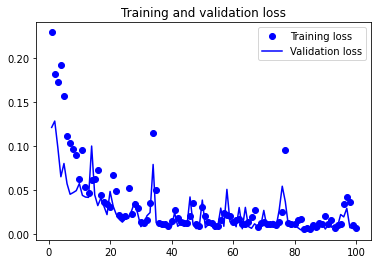

In [6]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<Figure size 1440x288 with 0 Axes>

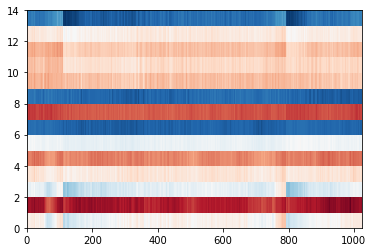

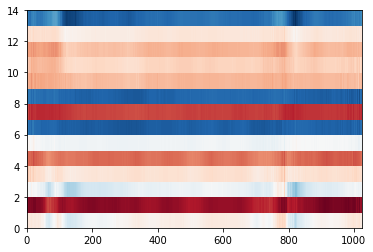

In [7]:

decoded_imgs = model.predict(dataX[150:150+2,:,:,:])

cmap = plt.get_cmap('RdBu')
n = 1
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    #ax = plt.subplot(2, n, i)
    plt.figure()
    plt.pcolormesh(dataX[150:150+2,:,:,:][i].reshape(14,1024),cmap=cmap)
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    plt.figure()
    
    #ax = plt.subplot(2, n, i + n)
    plt.pcolormesh(decoded_imgs[i].reshape(14,1024),cmap=cmap)
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.show()




In [8]:
model2=Model(inputs=model.input,outputs=encoder)
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14, 1024, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 1024, 128)     1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 1024, 128)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 512, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 512, 64)       73792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 512, 64)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 256, 64)       0   

(201, 14, 32, 2)
[0.15545732 0.15513527 0.15472338 0.15323478 0.17778614]
(201, 896)
[ 0.15545732 -0.10791297  0.15513527 -0.10782877  0.15472338]
(201, 2)
Explained variation per principal component: [0.46661112 0.16091318]


<Figure size 432x288 with 0 Axes>

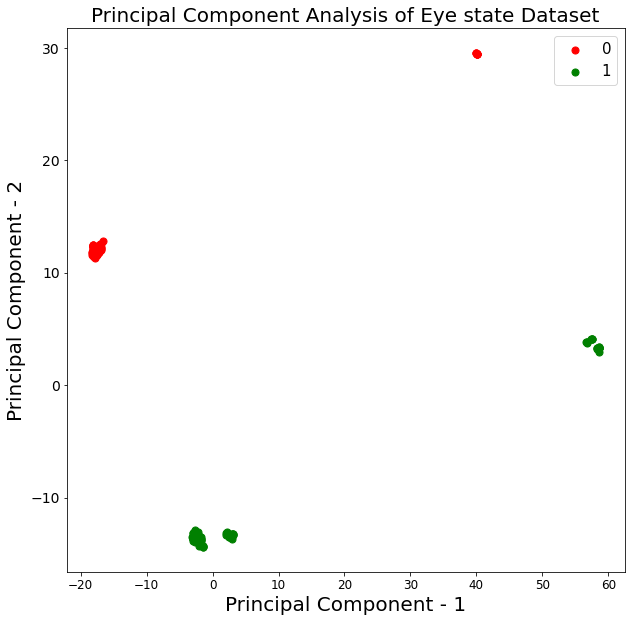

In [10]:
sizedata=201
decoded_imgs = model2.predict(dataX[0:sizedata,:,:,:])
print(np.shape(decoded_imgs))
print(decoded_imgs[0,0,0:5,0])
new=np.reshape(decoded_imgs,(sizedata,14*32*2))

print(np.shape(new))
print(new[0,0:5])
new = StandardScaler().fit_transform(new) # normalizing the features

new[dataY[0:sizedata]==1,:]=new[dataY[0:sizedata]==1,:]+1
pca_new = PCA(n_components=2)
new_pca = pca_new.fit_transform(new)
print(np.shape(new_pca))
new_pca_Df = pd.DataFrame(data = new_pca, columns = ['principal component 1', 'principal component 2'])
print('Explained variation per principal component: {}'.format(pca_new.explained_variance_ratio_))
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Eye state Dataset",fontsize=20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = dataY[0:sizedata] == target
    plt.scatter(new_pca_Df.loc[indicesToKeep, 'principal component 1']
               , new_pca_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

(201, 20)
[0.46661112 0.16091323 0.01235367 0.00964293 0.00962654 0.00953972
 0.00890248 0.00879472 0.00875589 0.00873628 0.00870316 0.0085782
 0.00845612 0.00843674 0.00841596 0.00838874 0.0083763  0.0083146
 0.00817322 0.00777856]


Text(0, 0.5, 'Cumulative explained variance')

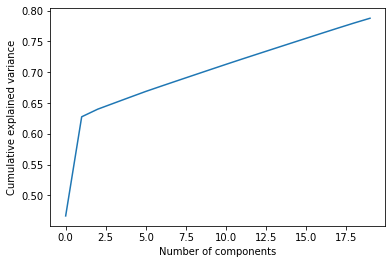

In [11]:
pca_new = PCA(n_components=20)
new_pca2 = pca_new.fit_transform(new)
print(np.shape(new_pca2))
print(pca_new.explained_variance_ratio_)
plt.plot(np.cumsum(pca_new.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [12]:
from sklearn.cluster import KMeans 
clusters = 4

kmeans = KMeans(n_clusters = clusters) 
kmeans.fit(new) 
print(kmeans.labels_)

[3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2]


In [23]:

finalPrediction=((kmeans.labels_==1)+(kmeans.labels_==3)).astype(int)
print(finalPrediction)
print((dataY).astype(int))
print("Accuracy: ",sum(finalPrediction==(dataY).astype(int))*100/201,"%")


Accuracy:  100.0 %


In [0]:
model.save('/content/Topology.h5')
model.save_weights('/content/Topology.hdf5')